# Precalificaciones rojas

Acá queremos ver qué política está dando más rechazo, por qué algunos clientes no se les ha podido dar salud financiera

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../db/precas.csv")

In [3]:
cols = ["dpi", "no_precalificacion", "SEGMENTO_PRODUCTO",
        'rciGlobalInicialDeudor', 'rciGlobalFinalDeudor',
       'rciInternoFinalDeudor', 'rciInternoInicialDeudor',
        "nombrepatrono", 'monto', 'plazo', 'tasa',
        'conSaldoCreditoBT', 'conSaldoCreditoExt', 'conSaldoFactorajeExt',
        'conSaldoTcBT', 'conSaldoTcExt', 'tipoCliente',
        "scoreDeudorInstallmentQnt",
        "scoreDeudorInstallmentQualPacing",
        "reglaNombre", "tipooferta", "Oferta"]

rojas = df[cols]
rojas = pd.get_dummies(rojas, columns=["reglaNombre"])

In [4]:
cols_one_hot = [col for col in rojas.columns if "reglaNombre_" in col]
rojas = rojas.groupby(by="dpi").agg({**{col: 'max' for col in cols_one_hot}, 
                                     **{col: "first" for col in rojas.columns.tolist() if col not in cols_one_hot
                                        and col != "dpi"}}).reset_index()

In [5]:
for col in cols_one_hot:
    rojas[col] = rojas[col].astype(str).str.replace("True", "1")
    rojas[col] = rojas[col].astype(str).str.replace("False", "0")
    rojas[col] = rojas[col].astype("int64")

In [6]:
rojas["NETO APROX"] = rojas["monto"] - rojas["conSaldoCreditoBT"]
rojas[rojas["reglaNombre_CREDITO CONSOLIDADO < 15% PAGADO"] == 1]["NETO APROX"].sum() / 10**6

253.39507236

## Evaluar qué razones de rechazo son las principales

In [7]:
conteo = {}
for col in cols_one_hot:
    conteo[col] = [rojas[col].sum()]

df_conteo = pd.DataFrame.from_dict(conteo)
df_conteo

,reglaNombre_CANCELACIONES CONTRA RESERVA,reglaNombre_CANTIDAD DE CREDITOS VIGENTES,reglaNombre_CATEGORIA PLASTICO,reglaNombre_CONTAGIO CREDITICIO,reglaNombre_CONTEO MORA 120,reglaNombre_CONTEO MORA 120+ SIRC,reglaNombre_CONTEO MORA 60,reglaNombre_CONTEO MORA 60+ SIRC,reglaNombre_CONTEO MORA 90,reglaNombre_CONTEO MORA 90+ SIRC,...,reglaNombre_RCI GLOBAL FINAL,reglaNombre_RCI GLOBAL INICIAL,reglaNombre_RCI INTERNO FINAL,reglaNombre_SALARIO MINIMO,reglaNombre_SCORE,reglaNombre_SCORE PREDICTIVO,reglaNombre_SIRC ACTUAL,reglaNombre_SOLICITA CODEUDOR,reglaNombre_TARJETAS PERMITIDAS EXTERNAS,reglaNombre_TARJETAS PERMITIDAS INTERNAS
0,3592,866,443,988,1414,551,2201,824,1150,415,...,11214,899,26737,303,902,3631,5285,9419,72,176


In [8]:
df_conteo.rename(columns={col: col[12:] for col in df_conteo.columns}, inplace=True)

### Graficar

In [9]:
import matplotlib.pyplot as plt
import numpy as np

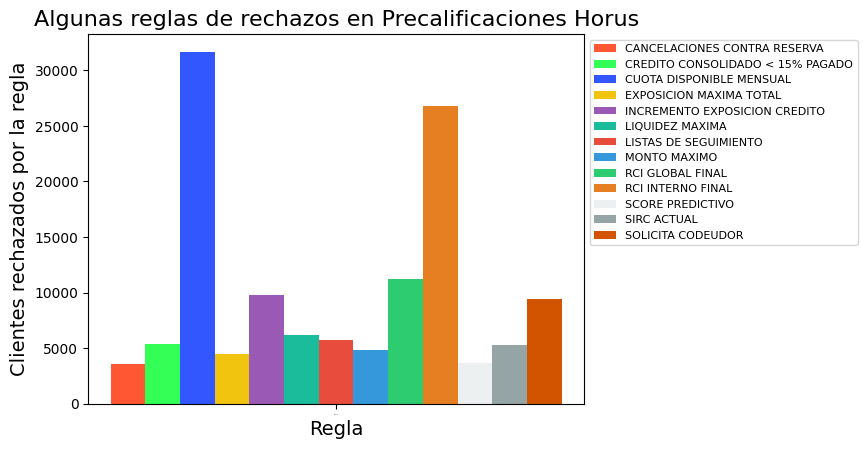

In [10]:
principales = []
for col in df_conteo.columns:
    if df_conteo.loc[0, col] >= 3500:
        principales.append(col)

df_principales = df_conteo[principales]

x = np.arange(len(df_principales))
colores = colores = [
    '#FF5733',  # Rojo anaranjado
    '#33FF57',  # Verde
    '#3357FF',  # Azul
    '#F1C40F',  # Amarillo
    '#9B59B6',  # Púrpura
    '#1ABC9C',  # Turquesa
    '#E74C3C',  # Rojo intenso
    '#3498DB',  # Azul claro
    '#2ECC71',  # Verde claro
    '#E67E22',  # Naranja
    '#ECF0F1',  # Gris claro
    '#95A5A6',  # Gris oscuro
    '#D35400',  # Naranja oscuro
    '#16A085',  # Verde azulado
    '#8E44AD',  # Púrpura oscuro
    '#27AE60',  # Verde fuerte
    '#2980B9',  # Azul intenso
    '#C0392B',  # Rojo fuerte
    '#F39C12',  # Amarillo anaranjado
    '#BDC3C7'   # Gris suave
]


# Crear el gráfico de barras para cada columna
width = 0.25  # El ancho de cada barra

fig, ax = plt.subplots()

for i, col in enumerate(principales):
    ax.bar(x + i * width - (len(principales) - 1) * width / 2, df_principales[col], width, label=col, color=colores[i])

# Añadir etiquetas y título
ax.set_xlabel('Regla', fontsize=14)
ax.set_ylabel('Clientes rechazados por la regla', fontsize=14)
ax.set_title('Algunas reglas de rechazos en Precalificaciones Horus', fontsize=16)

# Posicionar la leyenda
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

# Ajustar las etiquetas del eje X
ax.set_xticks(x)
ax.set_xticklabels([f'Fila {i}' for i in range(len(df_principales))], fontsize=1)

# Mostrar el gráfico
plt.show()

## Ver impactos de iniciativa

In [11]:
# cols_validas = ['reglaNombre_RCI GLOBAL INICIAL']

# filtro_validos = [col for col in cols_one_hot if col not in cols_validas]

# # Filtrar los clientes donde todas las columnas en 'cols_validas' son iguales a 0
# clientes_validos = rojas[(rojas[filtro_validos].eq(0).all(axis=1)) & (rojas["rciInternoFinalDeudor"] <= 60)]

clientes_validos = rojas[rojas["conSaldoCreditoExt"] <= 11000]
# Mostrar el resultado
len(clientes_validos)

33410

In [12]:
clientes_validos["conSaldoCreditoExt"].fillna(0, inplace=True)
clientes_validos = clientes_validos[~clientes_validos["conSaldoCreditoExt"].isna()]
sum(clientes_validos["conSaldoCreditoExt"] * clientes_validos["tasa"]) / sum(clientes_validos["conSaldoCreditoExt"])

C:\Users\mariajose_chinchilla\AppData\Local\Temp\ipykernel_7536\3571873695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_validos["conSaldoCreditoExt"].fillna(0, inplace=True)


20.86207431967591

In [13]:
clientes_validos["conSaldoCreditoExt"].sum() / 10**6

21.7733323

In [14]:
categorias = pd.read_csv("../../db/categorias.csv", sep=";")

In [15]:
clientes_validos_temp = pd.merge(clientes_validos, categorias, on="dpi", how="inner")

In [16]:
clientes_validos_temp["RESERVA CONTAGIO"] = clientes_validos_temp["reservas"] * clientes_validos_temp["conSaldoCreditoBT"]
clientes_validos_temp["RESERVA CONTAGIO"].sum() / 10**6

31.728243388051503

In [17]:
with open("../../db/dpis.txt", "w") as f:
    for dpi in clientes_validos["dpi"].unique().tolist():
        f.write(f"'{dpi}',")